In [1]:
import os
import numpy as np

import yaml
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request
import seaborn as sns

from OrderParameter import *

# Download link
def download_link(doi, file):
    if "zenodo" in doi.lower():
        zenodo_entry_number = doi.split(".")[2]
        return 'https://zenodo.org/record/' + zenodo_entry_number + '/files/' + file
    else:
        print ("DOI provided: {0}".format(doi))
        print ("Repository not validated. Please upload the data for example to zenodo.org")
        return ""
    
# read mapping file
def read_mapping_file(mapping_file, atom1):
    with open(mapping_file, 'rt') as mapping_file:
            for line in mapping_file:
                if atom1 in line:
                    m_atom1 = line.split()[1]
    return m_atom1

def read_mapping_filePAIR(mapping_file, atom1, atom2):
    with open(mapping_file, 'rt') as mapping_file:
            print(mapping_file)
            for line in mapping_file:
                if atom1 in line:
                    m_atom1 = line.split()[1]
#                    print(m_atom1)
                if atom2 in line: 
                    m_atom2 = line.split()[1]
#                    print(m_atom2)
    return m_atom1, m_atom2

def make_positive_angles(x):
    for i in range(len(x)):
        if x[i] < 0:
            x[i] = np.degrees(x[i]) + 360
        else:
            x[i] = np.degrees(x[i])
    return x

In [15]:
## Plot order parameter for selected DOIs

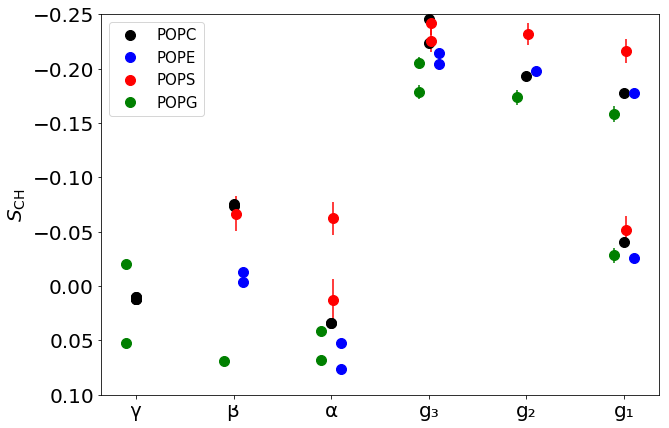

In [83]:
colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
markers = {'POPC' :'o','POPS':'o','POPE':'o','POPG':'o'}
lipids = {'POPC','POPS','POPE','POPG'}
xshifts = {'POPC' :0,'POPS':0.02,'POPE':0.1,'POPG':-0.1}
#lipids = {'POPC','POPE','POPG'}
DOIs = {'POPC' :'10.5281/zenodo.3474863','POPG' :'10.5281/zenodo.1011096','POPS' :'10.5281/zenodo.1129415','POPE' :'10.5281/zenodo.2641987'}

#data={'POPC':{0},'POPS':{0},'POPE':{0},'POPG':{0}}
#data2={'POPC':{0},'POPS':{0},'POPE':{0},'POPG':{0}}

countPOPS = 0

fig= plt.figure(figsize=(10,7))
for subdir, dirs, files in os.walk(r'../Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
               # print(readme)
            for lipid in lipids:
                if DOIs[lipid] in readme.get('DOI'):
                    OPfilepath = subdir + '/OrderParameters.json'
                    #print(OPfilepath)
                    #print(readme.get('SYSTEM'))
                    with open(OPfilepath) as json_file:
                        data[lipid] = json.load(json_file)
                        #try:
                        
                        #except:
                        #    data[lipid] = json.load(json_file)
                        #    print('excep')
                            
                    
for lipid in lipids:
    for key,value in data[lipid].items():
        #print (key,value[0][0],value[0][2])
        plt.gca().invert_yaxis()
                        
                        
        if lipid == 'POPG' and 'M_G3C6_M' in key:
            plt.plot(0+xshifts[lipid],value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
            plt.errorbar(0+xshifts[lipid],value[0][0],yerr=value[0][2],color=colors[lipid])
        if 'M_G3N6' in key:
            plt.plot(0+xshifts[lipid],value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
            plt.errorbar(0+xshifts[lipid],value[0][0],yerr=value[0][2],color=colors[lipid])
        if 'M_G3C5_M' in key:
            plt.plot(1+xshifts[lipid],value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
            plt.errorbar(1+xshifts[lipid],value[0][0],yerr=value[0][2],color=colors[lipid])
        if 'M_G3C4_M' in key:
            plt.plot(2+xshifts[lipid],value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
            plt.errorbar(2+xshifts[lipid],value[0][0],yerr=value[0][2],color=colors[lipid])
        if 'M_G3_M' in key:
            plt.plot(3+xshifts[lipid],value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
            plt.errorbar(3+xshifts[lipid],value[0][0],yerr=value[0][2],color=colors[lipid])
        if 'M_G2_M' in key:
            plt.plot(4+xshifts[lipid],value[0][0],"s",color=colors[lipid],label=lipid, marker=markers[lipid], markersize=10)
            plt.errorbar(4+xshifts[lipid],value[0][0],yerr=value[0][2],color=colors[lipid])
        if 'M_G1_M' in key:
            plt.plot(5+xshifts[lipid],value[0][0],"s",color=colors[lipid], marker=markers[lipid], markersize=10)
            plt.errorbar(5+xshifts[lipid],value[0][0],yerr=value[0][2],color=colors[lipid])
        
carbons = ['\u03B3','\u03B2','\u03B1','g\u2083','g\u2082','g\u2081']
xvalues = [0,1,2,3,4,5]
plt.legend(loc='best',ncol=1, fontsize=15)
plt.ylabel('$S_\mathrm{CH}$', fontsize=20)
plt.xticks(xvalues,carbons,fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.1,-0.25)
plt.savefig('../Figs/CHARMMfromLIPIDS.eps', bbox_inches='tight')
                    

rm: cannot remove 'data': No such file or directory


## Plot order parameters for each simulation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


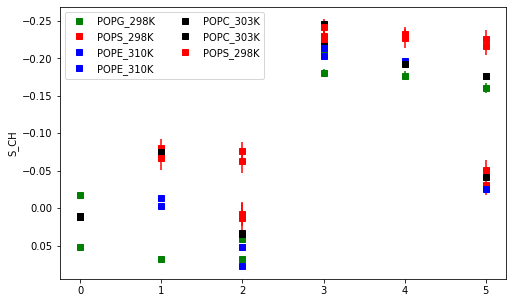

In [22]:
mapping_file = './mapping_files/'+readme['MAPPING_DICT'][molname] # readme.get('MAPPING')[0][0]
                                                
                        try:
                            atoms = read_mapping_filePAIR(mapping_file, atom1 , atom2)
                        except:
                            print(atom1 + " and " + atom2 + " not found in the mapping file.")
                            continue

colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
lipids = {'POPC','POPS','POPE','POPG'}


fig= plt.figure(figsize=(8,5))
for subdir, dirs, files in os.walk(r'/media/akiirikk/DATADRIVE1/tietokanta/NMRlipidsIVPEandPG/Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
               # print(readme)
            for lipid in lipids:
                if lipid in readme.get('SYSTEM') and sum(readme['N' + lipid]) > 0:
                    OPfilepath = subdir + '/OrderParameters.json'
                    #print(OPfilepath)
                    #print(readme.get('SYSTEM'))
                    with open(OPfilepath) as json_file:
                        data = json.load(json_file)
                    for key,value in data.items():
                       #print (key,value[0][0],value[0][2])
                        plt.gca().invert_yaxis()
                        plt.ylabel('S_CH')
                        
                        if lipid == 'POPG' and 'M_G3C6_M' in key:
                            plt.plot(0,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(0,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3N6' in key:
                            plt.plot(0,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(0,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3C5_M' in key:
                            plt.plot(1,value[0][0],"s",color=colors[lipid],label=readme.get('SYSTEM'))
                            plt.errorbar(1,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3C4_M' in key:
                            plt.plot(2,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(2,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G3_M' in key:
                            plt.plot(3,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(3,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G2_M' in key:
                            plt.plot(4,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(4,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'M_G1_M' in key:
                            plt.plot(5,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(5,value[0][0],yerr=value[0][2],color=colors[lipid])
            
plt.legend(loc='best',ncol=2)
plt.savefig('/media/akiirikk/DATADRIVE1/tietokanta/NMRlipidsIVPEandPG/Figs/CHARMMfromLIPIDS.eps')
                    

## Calculate and plot dihedral angles for each simulation

In [38]:
def calcDihedrals(lipids,DIHatoms):
    colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
    for subdir, dirs, files in os.walk(r'../Data/Simulations/'):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith("README.yaml"):
                READMEfilepath = subdir + '/README.yaml'
                with open(READMEfilepath) as yaml_file:
                    readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
                    for molname in lipids:
                        doi = readme.get('DOI')
                        trj = readme.get('TRJ')
                        tpr = readme.get('TPR')
                        trj_name = subdir + '/' + readme.get('TRJ')[0][0]
                        tpr_name = subdir + '/' + readme.get('TPR')[0][0]
                        gro_name = subdir + '/conf.gro'
                        trj_url = download_link(doi, trj[0][0])
                        tpr_url = download_link(doi, tpr[0][0])
    
                        #Download tpr and xtc files to same directory where dictionary and data are located
                        if (not os.path.isfile(tpr_name)):
                            response = urllib.request.urlretrieve(tpr_url, tpr_name)
                        
                        if (not os.path.isfile(trj_name)):
                            response = urllib.request.urlretrieve(trj_url, trj_name)
                
                        if sum(readme['N' + molname]) > 0:
                            print('Analyzing '+molname+' in '+filepath)
                            #fig= plt.figure(figsize=(12,9))
                            if (not os.path.isfile(gro_name)):
                                !echo System | gmx trjconv -f {trj_name} -s {tpr_name}  -dump 0 -o {gro_name}
                        
                            xtcwhole=subdir + '/whole.xtc'
                            if (not os.path.isfile(xtcwhole)):
                                !echo System | gmx trjconv -f {trj_name} -s {tpr_name} -o {xtcwhole} -pbc mol 
                        
                            try:
                                traj = mdtraj.load(xtcwhole, top = gro_name)
                                #print(lipid)
                            except FileNotFoundError or OSError:
                                continue
                       
                            mapping_file = './mapping_files/'+readme['MAPPING_DICT'][molname] # readme.get('MAPPING')[0][0]
                            try:
                                atom1 = read_mapping_file(mapping_file, DIHatoms[0])
                                atom2 = read_mapping_file(mapping_file, DIHatoms[1])
                                atom3 = read_mapping_file(mapping_file, DIHatoms[2])
                                atom4 = read_mapping_file(mapping_file, DIHatoms[3])
                                print(atom1,atom2,atom3,atom4)
                            except:
                                #print(atom1 + " and " + atom2 + " not found in the mapping file.")
                                print("Some atom not found in the mapping file.")
                                continue
                            index = [ [] for i in range(traj.topology.n_residues)]
                            dihRESULT = []
                            for residue in traj.topology.residues:
                                atom1ind=traj.topology.select("name == " + atom1 + " and resid == " + str(residue.index))
                                atom2ind=traj.topology.select("name == " + atom2 + " and resid == " + str(residue.index))
                                atom3ind=traj.topology.select("name == " + atom3 + " and resid == " + str(residue.index))
                                atom4ind=traj.topology.select("name == " + atom4 + " and resid == " + str(residue.index))
                                if(len(atom1ind) > 0):
                                    index[residue.index].append(atom1ind[0])
                                    index[residue.index].append(atom2ind[0])
                                    index[residue.index].append(atom3ind[0])
                                    index[residue.index].append(atom4ind[0])
                                    dihRESULT.append(mdtraj.compute_dihedrals(traj,[index[residue.index]]))
                                
                            dihRESULT = [make_positive_angles(x) for x in dihRESULT ]
                            dist = [ 0 for i in range(len(dihRESULT))]
                            distSUM = [ 0 for i in range(359)]
                            for i in range(len(dihRESULT)):
                                dist[i] =  plt.hist(dihRESULT[i], range(360),density=True);
                                distSUM = np.add(distSUM,dist[i][0])
                            
                        
                            distSUM = [x / len(dihRESULT) for x in distSUM]
                            xaxis = [ 0 for i in range(len(dist[0][1])-1)]
                            for i in range(len(dist[0][1])-1):
                                xaxis[i]=(dist[0][1][i])
                            
                            plt.plot(xaxis,distSUM,color=colors[molname], label = readme.get('SYSTEM'))[0] 
                            plt.legend()
                            plt.xlabel("Angle (°)")
                        
                            dihedralFOLDERS = subdir.replace("Simulations","dihedral")
                            !mkdir -p {dihedralFOLDERS}
                            !cp {READMEfilepath} {dihedralFOLDERS}
                            outfile=open(str(dihedralFOLDERS) + '/' + DIHatoms[0] + DIHatoms[1] + DIHatoms[2] + DIHatoms[3] +'.dat','w')
                            for i in range(len(xaxis)):
                                outfile.write(str(xaxis[i]) + " " + str(distSUM[i])+'\n')
                            outfile.close()
                        

In [ ]:
lipids = {'POPC','POPS','POPE','POPG'}
#lipids = {'POPS'}
#lipids = {'POPG','POPE','POPC'}
#DIHatoms = ['M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M','M_G3N6_M']
#DIHatoms = ['M_G3C5_M', 'M_G3C4_M', 'M_G3O3_M','M_G3P2_M' ]
for i in dihedrals:
    DIHatoms = i
    calcDihedrals(lipids,i)



Analyzing POPG in ../Data/Simulations/0d5/d1d/0d5d1dcb43e775faf4e53c4f9ff255a67481bd38/9b487701b24d3fad83991e311188b08d3d5ea768/README.yaml
C316 C315 C314 C313
Analyzing POPS in ../Data/Simulations/1b2/6e6/1b26e6c750b4f39c37770422cd4d3c40240cf111/995bc873b811ca09c916b47784fa33bb9d793732/README.yaml
C316 C315 C314 C313
Analyzing POPE in ../Data/Simulations/2d4/61b/2d461bc9d828af155146162ef42438974e4cbeaf/c8ce4cc36ef6ec7a085cf011176a92d9d746a792/README.yaml
C316 C315 C314 C313
Analyzing POPC in ../Data/Simulations/b4f/866/b4f866c0dabffa6cd891e91841591d46590f34aa/a231c358dd8c0b7bb4cf558ccdbf022373354a9a/README.yaml
C316 C315 C314 C313
Analyzing POPS in ../Data/Simulations/f40/bb6/f40bb6ab5d44402be07059e8df74b5a8200f031e/6774168dfec0a5a7377c8a46341eba603f320cf7/README.yaml
C316 C315 C314 C313
Analyzing POPG in ../Data/Simulations/0d5/d1d/0d5d1dcb43e775faf4e53c4f9ff255a67481bd38/9b487701b24d3fad83991e311188b08d3d5ea768/README.yaml
C315 C314 C313 C312
Analyzing POPS in ../Data/Simulations/1b

In [ ]:
dihRESULTall = []
#dihRESULTsum=np.add(dihRESULT[5],dihRESULT[5]*-1)
#sum=0ihRESULTsum=np.add(dihRESULTsum,dihRESULT[i])
#print(dihRESULTsum)
#dihRESULTsum=np.add(dihRESULTsum,dihRESULT[9])
#print(dihRESULTsum)
#dihRESULTsum=np.add(dihRESULTsum,dihRESULT[10])
for i in range(traj.topology.n_residues):
    if(len(dihRESULT[i]) > 0):
        dihRESULTall=dihRESULT[0] + dihRESULT[i]
print(dihRESULTall)



In [5]:
dihedralFOLDERS = subdir.replace("Simulations","dihedral")
!mkdir -p {dihedralFOLDERS}
!cp {READMEfilepath} {dihedralFOLDERS}
outfile=open(str(dihedralFOLDERS) + '/' + DIHatoms[0] + DIHatoms[1] + DIHatoms[2] + DIHatoms[3] +'.dat','w')
for i in range(len(xaxis)):
    outfile.write(str(xaxis[i]) + " " + str(distSUM[i])+'\n')
outfile.close()
                        

In [ ]:
dist = [ 0 for i in range(len(dihRESULT))]
distSUM = [ 0 for i in range(50)]
for i in range(len(dihRESULT)):
    dist[i] =  plt.hist(dihRESULT[i], bins=50)
    distSUM = np.add(distSUM,dist[i][0])
    #print(dist[i][0])
    #print(distSUM)

In [ ]:
#totDIST=[distSUM,dist[0][1]]
#print(totDIST)
#print(dihRESULT[0])
#print(dist[0])
print(distSUM)
xaxis = [ 0 for i in range(len(dist[0][1])-1)]
for i in range(len(dist[0][1])-1):
    xaxis[i]=(dist[0][1][i])
    print(xaxis)
plt.plot(xaxis,distSUM)

In [ ]:
dihs = top.select("name == P or name == C11 or name == C12 or name == N")
index = [ [] for i in range(traj.topology.n_residues)]
dihRESULT = [ [] for i in range(traj.topology.n_residues)]
for residue in traj.topology.residues:
    for i in dihs:
        if(traj.topology.atom(i).residue == residue): 
            index[residue.index].append(traj.topology.atom(i).index)
    dihRESULT[residue.index] = mdtraj.compute_dihedrals(traj,[index[residue.index]])
    print(dihRESULT[residue.index])

In [ ]:
mdtraj.compute_dihedrals(traj,[dihs])

In [ ]:
top

In [48]:
mapping_file = "./mapping_files/mappingPOPEcharmm.txt"
#dihedrals = parseDihedralInput(mapping_file)
parseDihedralInput(mapping_file)


['M_G1C17_M', 'M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M', 'M_G1C7_M', 'M_G1C6_M', 'M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M', 'M_G1C2O1_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G1_M']
['M_G2C19_M', 'M_G2C18_M', 'M_G2C17_M', 'M_G2C16_M', 'M_G2C15_M', 'M_G2C14_M', 'M_G2C13_M', 'M_G2C12_M', 'M_G2C11_M', 'M_G2C10_M', 'M_G2C9_M', 'M_G2C8_M', 'M_G2C7_M', 'M_G2C6_M', 'M_G2C5_M', 'M_G2C4_M', 'M_G2C3_M', 'M_G2C2O1_M', 'M_G2C2_M', 'M_G2O1_M', 'M_G2_M']
['M_G3_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3P2O1_M', 'M_G3P2O2_M', 'M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M', 'M_G3N6_M']
['M_G1C17_M', 'M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M']
['M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M']
['M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M']
['M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M']
['M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M']
['M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M']
['M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M']
['M_G1C10_M', 'M_G1C9

[]

In [52]:
dihedrals=[['M_G1C17_M', 'M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M'],
['M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M'],
['M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M'],
['M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M'],
['M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M'],
['M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M'],
['M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M'],
['M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M', 'M_G1C7_M'],
['M_G1C9_M', 'M_G1C8_M', 'M_G1C7_M', 'M_G1C6_M'],
['M_G1C8_M', 'M_G1C7_M', 'M_G1C6_M', 'M_G1C5_M'],
['M_G1C7_M', 'M_G1C6_M', 'M_G1C5_M', 'M_G1C4_M'],
['M_G1C6_M', 'M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M'],
['M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M', 'M_G1C2O1_M'],
['M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M', 'M_G1C2_M'],
['M_G1C4_M', 'M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M'],
['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G1_M'],
['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G3_M'],
['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G3O1_M'],
['M_G1C2_M', 'M_G1O1_M', 'M_G3O1_M', 'M_G3P2_M'],
['M_G1O1_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3P2O1_M'],
['M_G1O1_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3P2O2_M'],
['M_G1O1_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3O3_M'],
['M_G3O1_M', 'M_G3P2_M', 'M_G3O3_M', 'M_G3C4_M'],
['M_G3P2_M', 'M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M'],
['M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M', 'M_G3N6_M'],
['M_G2C19_M', 'M_G2C18_M', 'M_G2C17_M', 'M_G2C16_M'],
['M_G2C18_M', 'M_G2C17_M', 'M_G2C16_M', 'M_G2C15_M'],
['M_G2C17_M', 'M_G2C16_M', 'M_G2C15_M', 'M_G2C14_M'],
['M_G2C16_M', 'M_G2C15_M', 'M_G2C14_M', 'M_G2C13_M'],
['M_G2C15_M', 'M_G2C14_M', 'M_G2C13_M', 'M_G2C12_M'],
['M_G2C14_M', 'M_G2C13_M', 'M_G2C12_M', 'M_G2C11_M'],
['M_G2C13_M', 'M_G2C12_M', 'M_G2C11_M', 'M_G2C10_M'],
['M_G2C12_M', 'M_G2C11_M', 'M_G2C10_M', 'M_G2C9_M'],
['M_G2C11_M', 'M_G2C10_M', 'M_G2C9_M', 'M_G2C8_M'],
['M_G2C10_M', 'M_G2C9_M', 'M_G2C8_M', 'M_G2C7_M'],
['M_G2C9_M', 'M_G2C8_M', 'M_G2C7_M', 'M_G2C6_M'],
['M_G2C8_M', 'M_G2C7_M', 'M_G2C6_M', 'M_G2C5_M'],
['M_G2C7_M', 'M_G2C6_M', 'M_G2C5_M', 'M_G2C4_M'],
['M_G2C6_M', 'M_G2C5_M', 'M_G2C4_M', 'M_G2C3_M'],
['M_G2C5_M', 'M_G2C4_M', 'M_G2C3_M', 'M_G2C2O1_M'],
['M_G2C5_M', 'M_G2C4_M', 'M_G2C3_M', 'M_G2C2_M'],
['M_G2C4_M', 'M_G2C3_M', 'M_G2C2_M', 'M_G2O1_M'],
['M_G2C3_M', 'M_G2C2_M', 'M_G2O1_M', 'M_G2_M'],
['M_G2C3_M', 'M_G2C2_M', 'M_G2O1_M', 'M_G3_M'],
['M_G2C3_M', 'M_G2C2_M', 'M_G2O1_M', 'M_G3O1_M'],
['M_G2C2_M', 'M_G2O1_M', 'M_G3O1_M', 'M_G3P2_M'],
['M_G2O1_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3P2O1_M'],
['M_G2O1_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3P2O2_M'],
['M_G2O1_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3O3_M'],
['M_G3O1_M', 'M_G3P2_M', 'M_G3O3_M', 'M_G3C4_M'],
['M_G3P2_M', 'M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M'],
['M_G3O3_M', 'M_G3C4_M', 'M_G3C5_M', 'M_G3N6_M'],
]


In [53]:
dihedrals

[['M_G1C17_M', 'M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M'],
 ['M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M'],
 ['M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M'],
 ['M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M'],
 ['M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M'],
 ['M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M'],
 ['M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M'],
 ['M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M', 'M_G1C7_M'],
 ['M_G1C9_M', 'M_G1C8_M', 'M_G1C7_M', 'M_G1C6_M'],
 ['M_G1C8_M', 'M_G1C7_M', 'M_G1C6_M', 'M_G1C5_M'],
 ['M_G1C7_M', 'M_G1C6_M', 'M_G1C5_M', 'M_G1C4_M'],
 ['M_G1C6_M', 'M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M'],
 ['M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M', 'M_G1C2O1_M'],
 ['M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M', 'M_G1C2_M'],
 ['M_G1C4_M', 'M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M'],
 ['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G1_M'],
 ['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G3_M'],
 ['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G3O1_M'],
 ['M_G1C2_M', 'M_G1O1_M', 'M_G3O1_M', 'M_G3P2_M'],
 ['M_G1

In [54]:
for i in dihedrals:
    DIHatoms = i
    print(i)

['M_G1C17_M', 'M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M']
['M_G1C16_M', 'M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M']
['M_G1C15_M', 'M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M']
['M_G1C14_M', 'M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M']
['M_G1C13_M', 'M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M']
['M_G1C12_M', 'M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M']
['M_G1C11_M', 'M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M']
['M_G1C10_M', 'M_G1C9_M', 'M_G1C8_M', 'M_G1C7_M']
['M_G1C9_M', 'M_G1C8_M', 'M_G1C7_M', 'M_G1C6_M']
['M_G1C8_M', 'M_G1C7_M', 'M_G1C6_M', 'M_G1C5_M']
['M_G1C7_M', 'M_G1C6_M', 'M_G1C5_M', 'M_G1C4_M']
['M_G1C6_M', 'M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M']
['M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M', 'M_G1C2O1_M']
['M_G1C5_M', 'M_G1C4_M', 'M_G1C3_M', 'M_G1C2_M']
['M_G1C4_M', 'M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M']
['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G1_M']
['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G3_M']
['M_G1C3_M', 'M_G1C2_M', 'M_G1O1_M', 'M_G3O1_M']
['M_G1C2_M', 'M_G1O1_M', 'M_G3O1_M', 'M_G3P2_M']
['M_G1O1_M', 'M_G3O1_M', 'M_G3P2_M', 'M_G3P2O